In [117]:
import numpy as np; import pandas as pd
from datetime import datetime, date, timezone
import json, sys, matplotlib, glob, pytz, sys
import seaborn as sns; 
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter

%matplotlib inline
%config InlineBackend.figure_format = 'retina';

# "Enriched Changeset" Analysis 
With the following query on Amazon Athena, we can create **enriched changesets** that combine both object and changeset metadata.

```sql
WITH changeset_stats AS 
    (SELECT id,
         uid,
         num_changes,
         created_at,
         "user" as username,
         tags['comment'] as changeset_comment,
         SPLIT(tags['hashtags'],';') as changeset_hashtags,
         SPLIT(tags['created_by'],' ')[1] as created_by,
         SPLIT(tags['imagery_used'],';') as imagery_used,
         (min_lon+max_lon)/2 AS LON,
         (min_lat+max_lat)/2 AS LAT
    FROM changesets
    WHERE       min_lat > 4.07
            AND max_lat < 13.89
            AND min_lon > 2.68
            AND max_lon < 14.68
    ORDER BY  created_at DESC)    
    
SELECT   
         changeset_stats.*,
         count(planet_history.id) AS objects,
         CAST(histogram(version) as JSON) AS versions,
         CAST(histogram(planet_history.tags['highway'])  AS JSON)  AS highways, 
         CAST(histogram(planet_history.tags['building']) AS JSON) AS buildings,
         CAST(histogram(planet_history.tags['amenity'])  AS JSON)  AS amenities
FROM planet_history 
LEFT JOIN changeset_stats ON planet_history.changeset = changeset_stats.id
WHERE cardinality(planet_history.tags) > 0
GROUP BY  changeset_stats.id, 
          changeset_stats.uid, 
          changeset_stats.created_at,
          username,
          changeset_comment,
          changeset_hashtags,
          changeset_stats.num_changes,
          created_by,
          imagery_used, changeset_stats.LON,changeset_stats.LAT
ORDER BY  changeset_stats.id DESC
```

### Bounding Box: 

<img src="https://i.imgur.com/4eKHAjM.png" width="250">

In [118]:
FILE = 'nigeria_enriched.csv'

In [119]:
df = pd.read_csv(FILE, low_memory=False)
print("Read {:,} changesets from {}".format(len(df), FILE))

Read 520,371 changesets from nigeria_enriched.csv


In [120]:
#Atomic changes
df.created_at = df.created_at.apply(pd.Timestamp)
df['date']    = df.created_at.apply(pd.Timestamp.date)
df.buildings  = df.buildings.apply(lambda h: json.loads(h) if not pd.isnull(h) else False)
df.highways   = df.highways.apply(lambda h: json.loads(h) if not pd.isnull(h) else False)
df.amenities  = df.amenities.apply(lambda h: json.loads(h) if not pd.isnull(h) else False)
df.head(2)

,id,uid,num_changes,created_at,username,changeset_comment,changeset_hashtags,created_by,imagery_used,LON,LAT,objects,versions,highways,buildings,amenities,date
0,92315553,4655096,32,2020-10-11 22:46:26,NANDJO,#hotosm-project-9352 #UIMappers #MapOyo #MapOy...,"[#hotosm-project-9352, #UIMappers, #MapOyo, #M...",JOSM/1.5,NaN,3.940453,7.817153,18,"{""1"":3,""2"":11,""3"":3,""4"":1}",{'residential': 17},{'yes': 1},False,2020-10-11
1,92315326,4655096,1901,2020-10-11 22:27:31,NANDJO,#hotosm-project-9352 #UIMappers #MapOyo #MapOy...,"[#hotosm-project-9352, #UIMappers, #MapOyo, #M...",JOSM/1.5,NaN,3.941269,7.817796,364,"{""1"":364}",False,{'yes': 364},False,2020-10-11


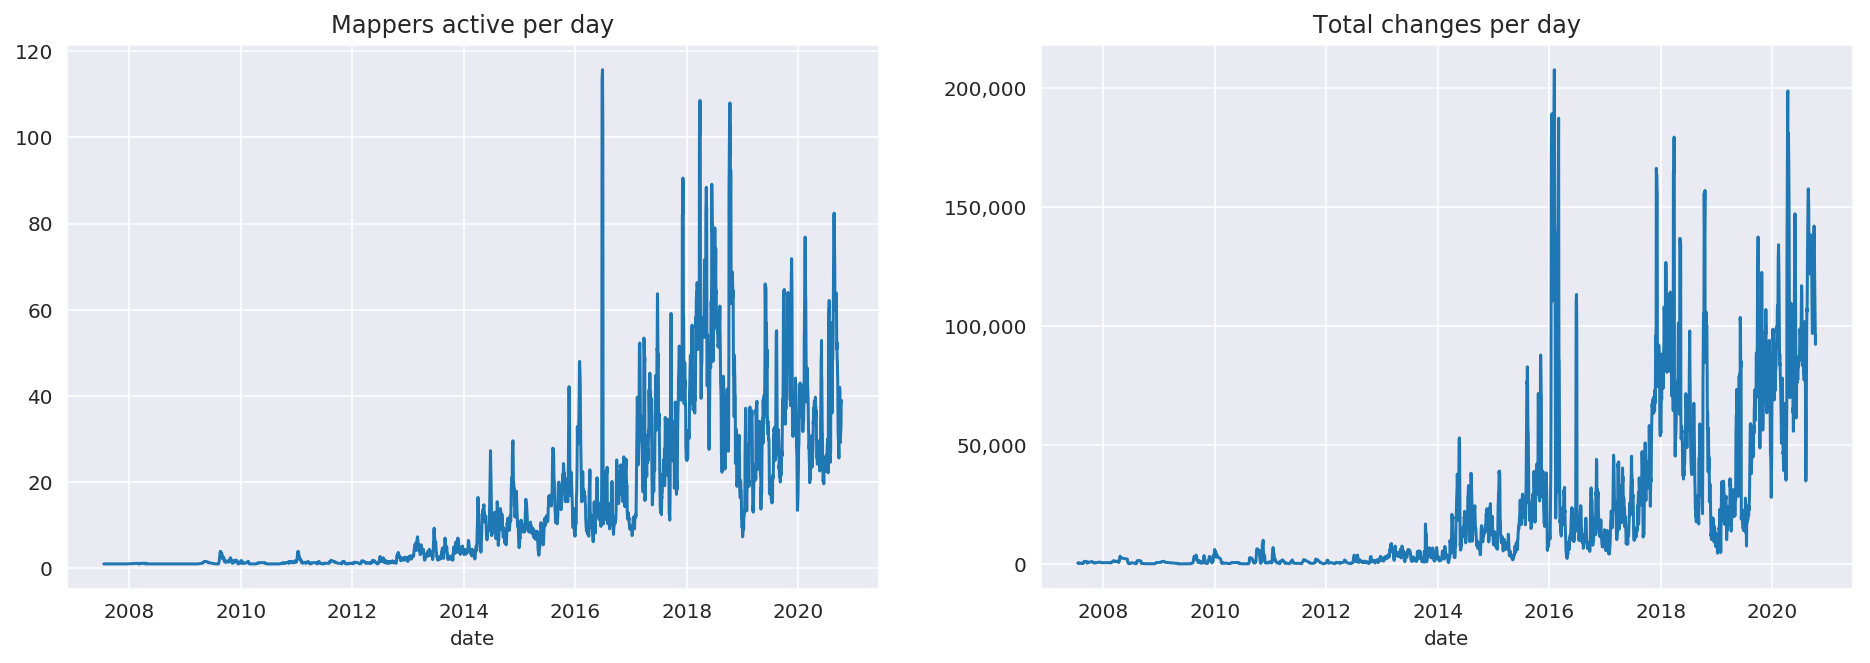

In [121]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(1,2,figsize=(16,5)); 
gb_date = df.groupby('date').aggregate({'uid':'nunique','num_changes':sum})
gb_date['uid'].rolling(7).mean().plot(ax=axes[0]); 
gb_date['num_changes'].rolling(7).mean().plot(ax=axes[1])
axes[0].set_title("Mappers active per day");
axes[1].set_title("Total changes per day");
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{:,}".format(int(x))))

In [122]:
# How about buildings edited per day?
buildings = pd.DataFrame(df[~pd.isna(df.buildings) & ~(df.buildings==False)])
buildings['b_count'] = buildings.buildings.apply(lambda x: pd.Series(list(x.values())).sum())

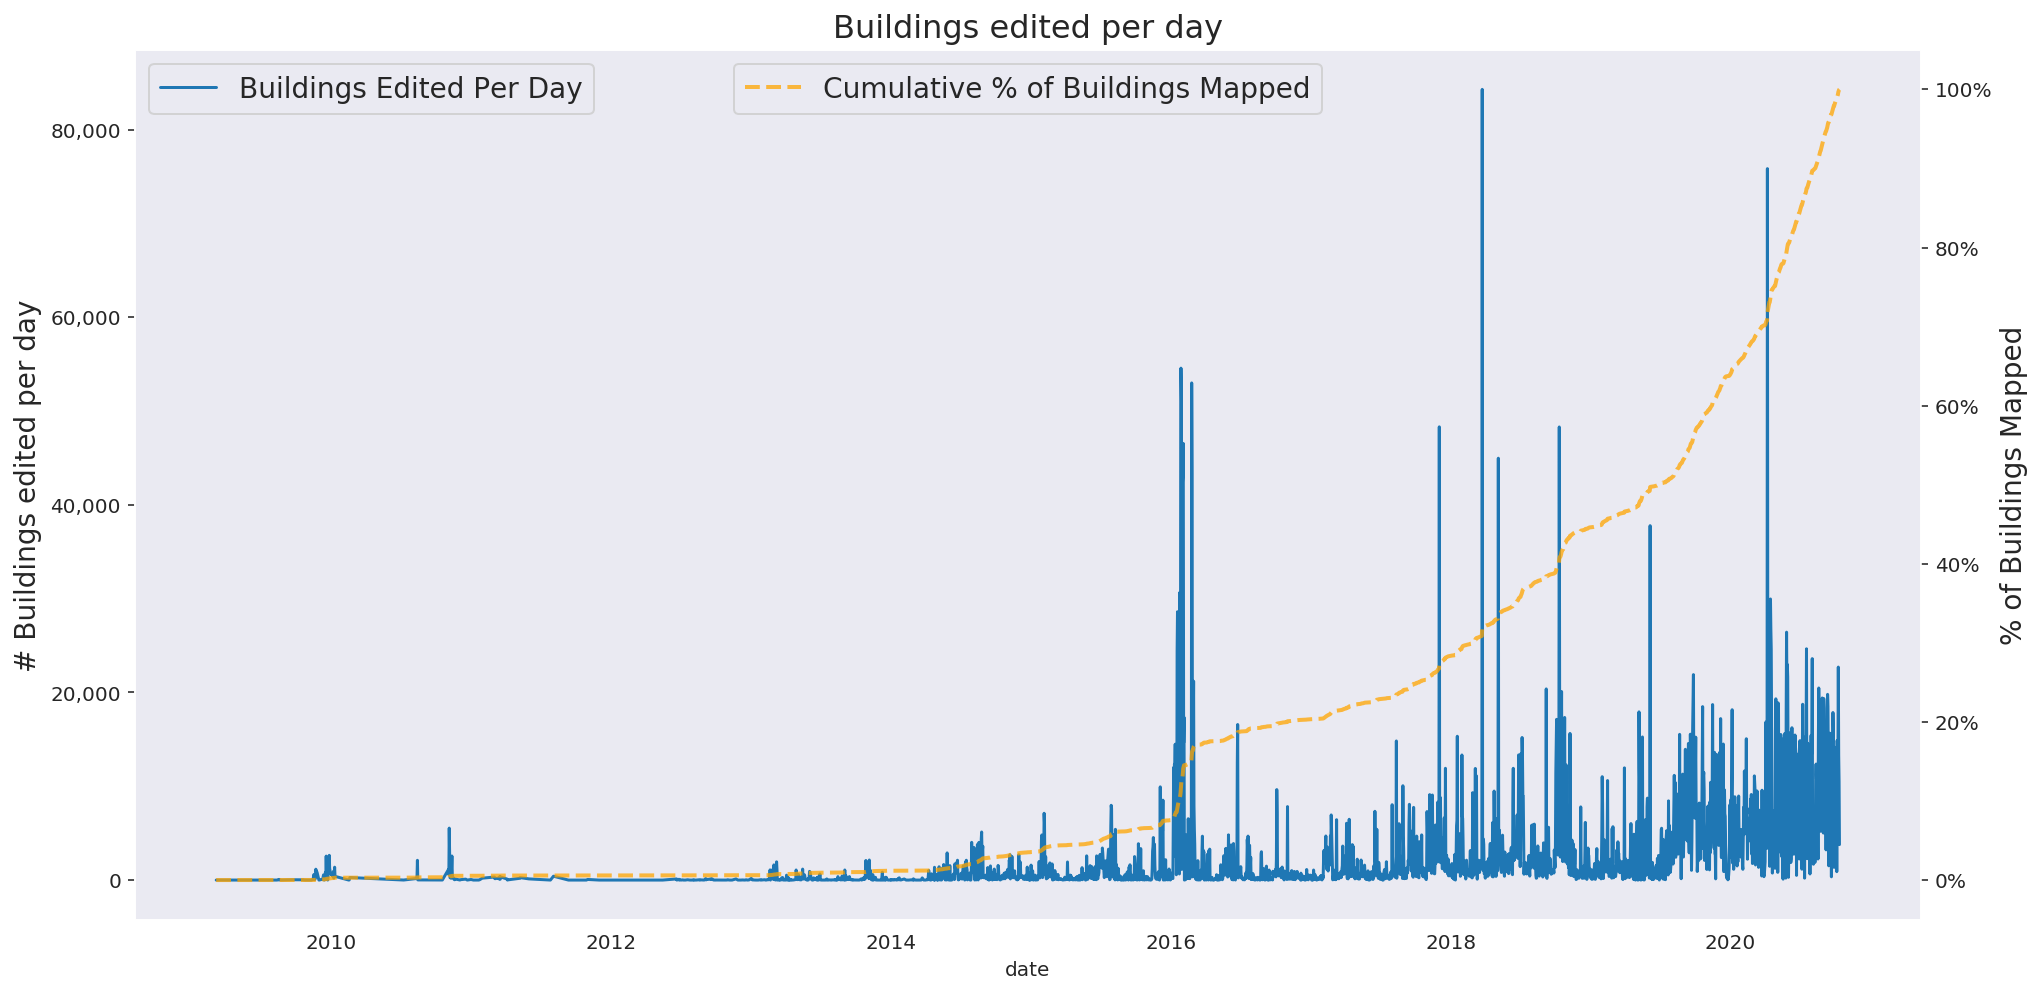

In [124]:
sns.set_style("dark")
b_gb_date = buildings.groupby('date').aggregate({'b_count':sum})
ax  = b_gb_date.plot(figsize=(16,8), legend=None)
ax2 = (b_gb_date.cumsum() / b_gb_date.b_count.sum()*100).plot(ax=ax.twinx(), legend=None, 
      color='orange', style="--", alpha=0.75, lw=2)
ax.set_title("Buildings edited per day", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{:,}".format(int(x))))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}%".format(int(x))))
ax.legend(["Buildings Edited Per Day"], loc='upper left', fontsize=14)
ax2.legend(["Cumulative % of Buildings Mapped"], loc='upper center', fontsize=14);
ax.set_ylabel("# Buildings edited per day", fontsize=14)
ax2.set_ylabel("% of Buildings Mapped", fontsize=14);

## Highways

In [125]:
highways = pd.DataFrame(df[~pd.isna(df.highways) & ~(df.highways==False)])
highways['hw_count'] = highways.highways.apply(lambda x: pd.Series(list(x.values())).sum())

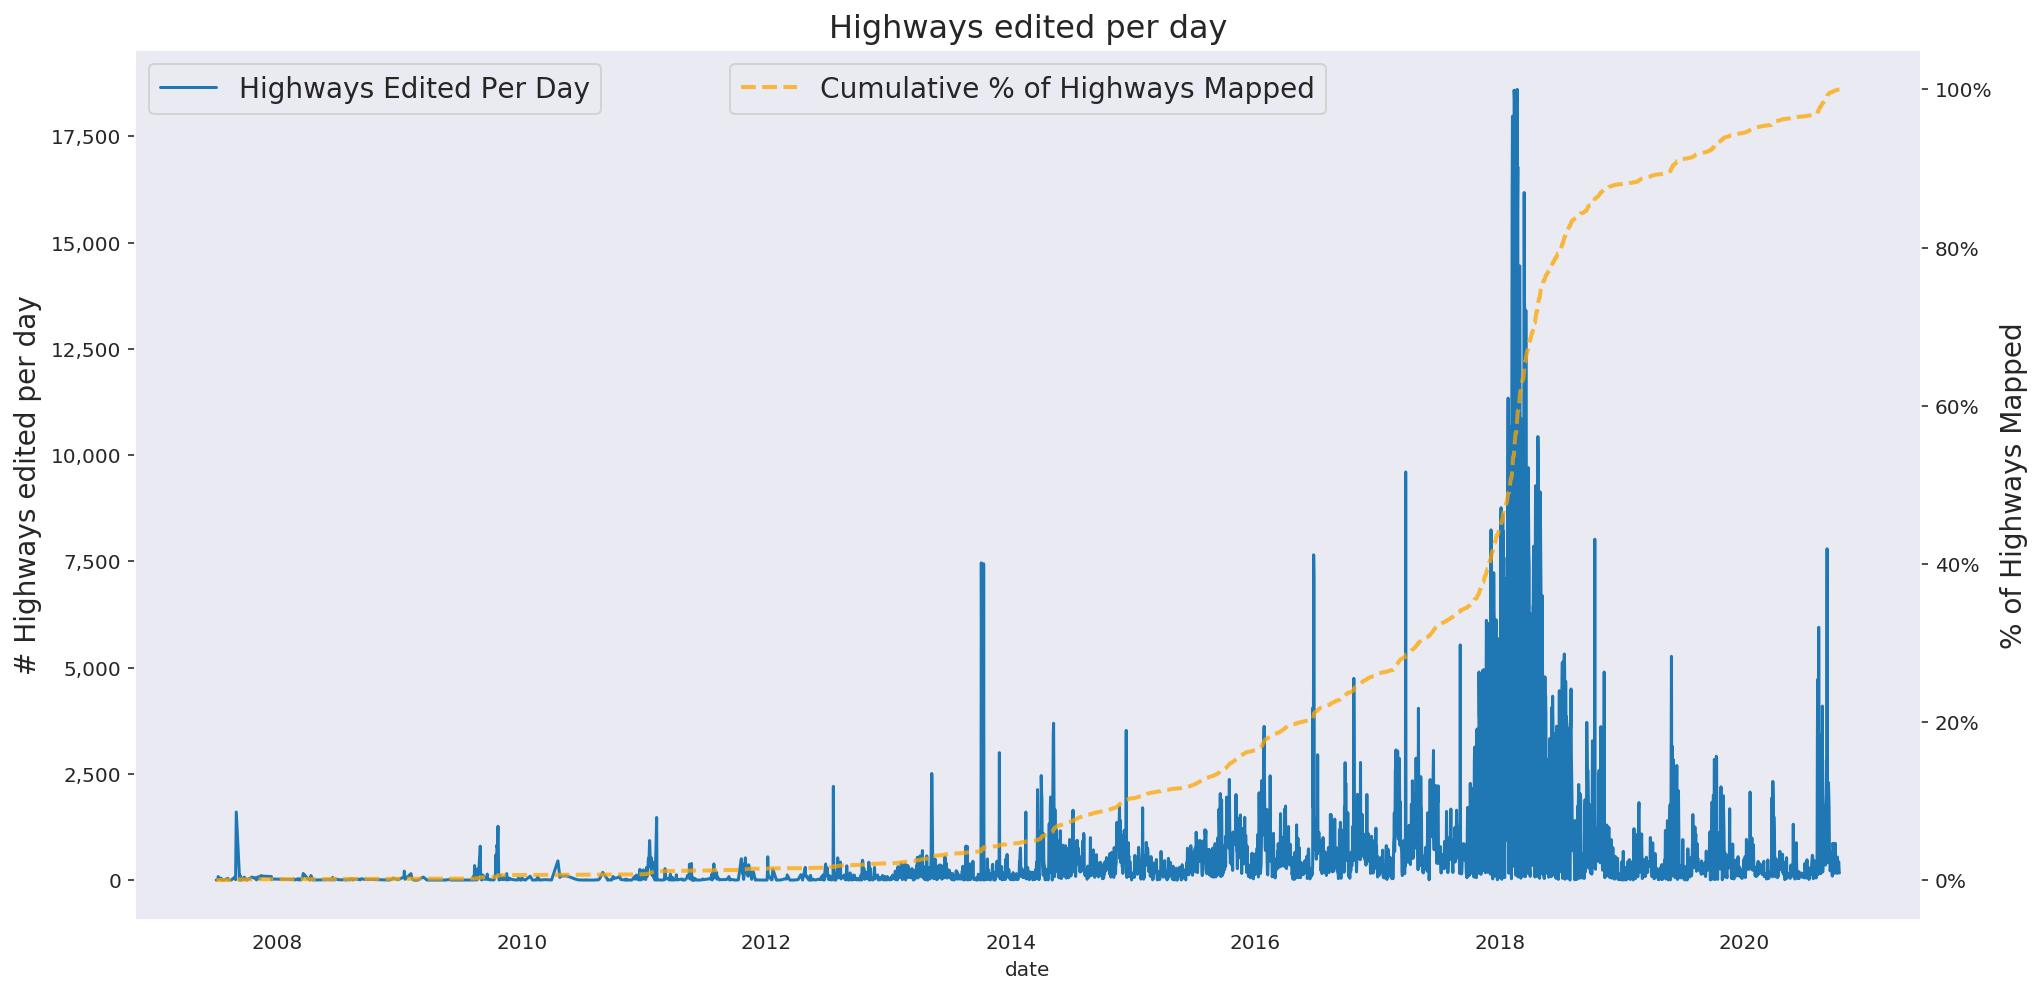

In [126]:
sns.set_style("dark")
hw_gb_date = highways.groupby('date').aggregate({'hw_count':sum})
ax  = hw_gb_date.plot(figsize=(16,8), legend=None)
ax2 = (hw_gb_date.cumsum() / hw_gb_date.hw_count.sum()*100).plot(ax=ax.twinx(), legend=None, 
      color='orange', style="--", alpha=0.75, lw=2)
ax.set_title("Highways edited per day", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{:,}".format(int(x))))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}%".format(int(x))))
ax.legend(["Highways Edited Per Day"], loc='upper left', fontsize=14)
ax2.legend(["Cumulative % of Highways Mapped"], loc='upper center', fontsize=14);
ax.set_ylabel("# Highways edited per day", fontsize=14)
ax2.set_ylabel("% of Highways Mapped", fontsize=14);

## Amenities

In [127]:
amenities = pd.DataFrame(df[~pd.isna(df.amenities) & ~(df.amenities==False)])
amenities['a_count'] = amenities.amenities.apply(lambda x: pd.Series(list(x.values())).sum())

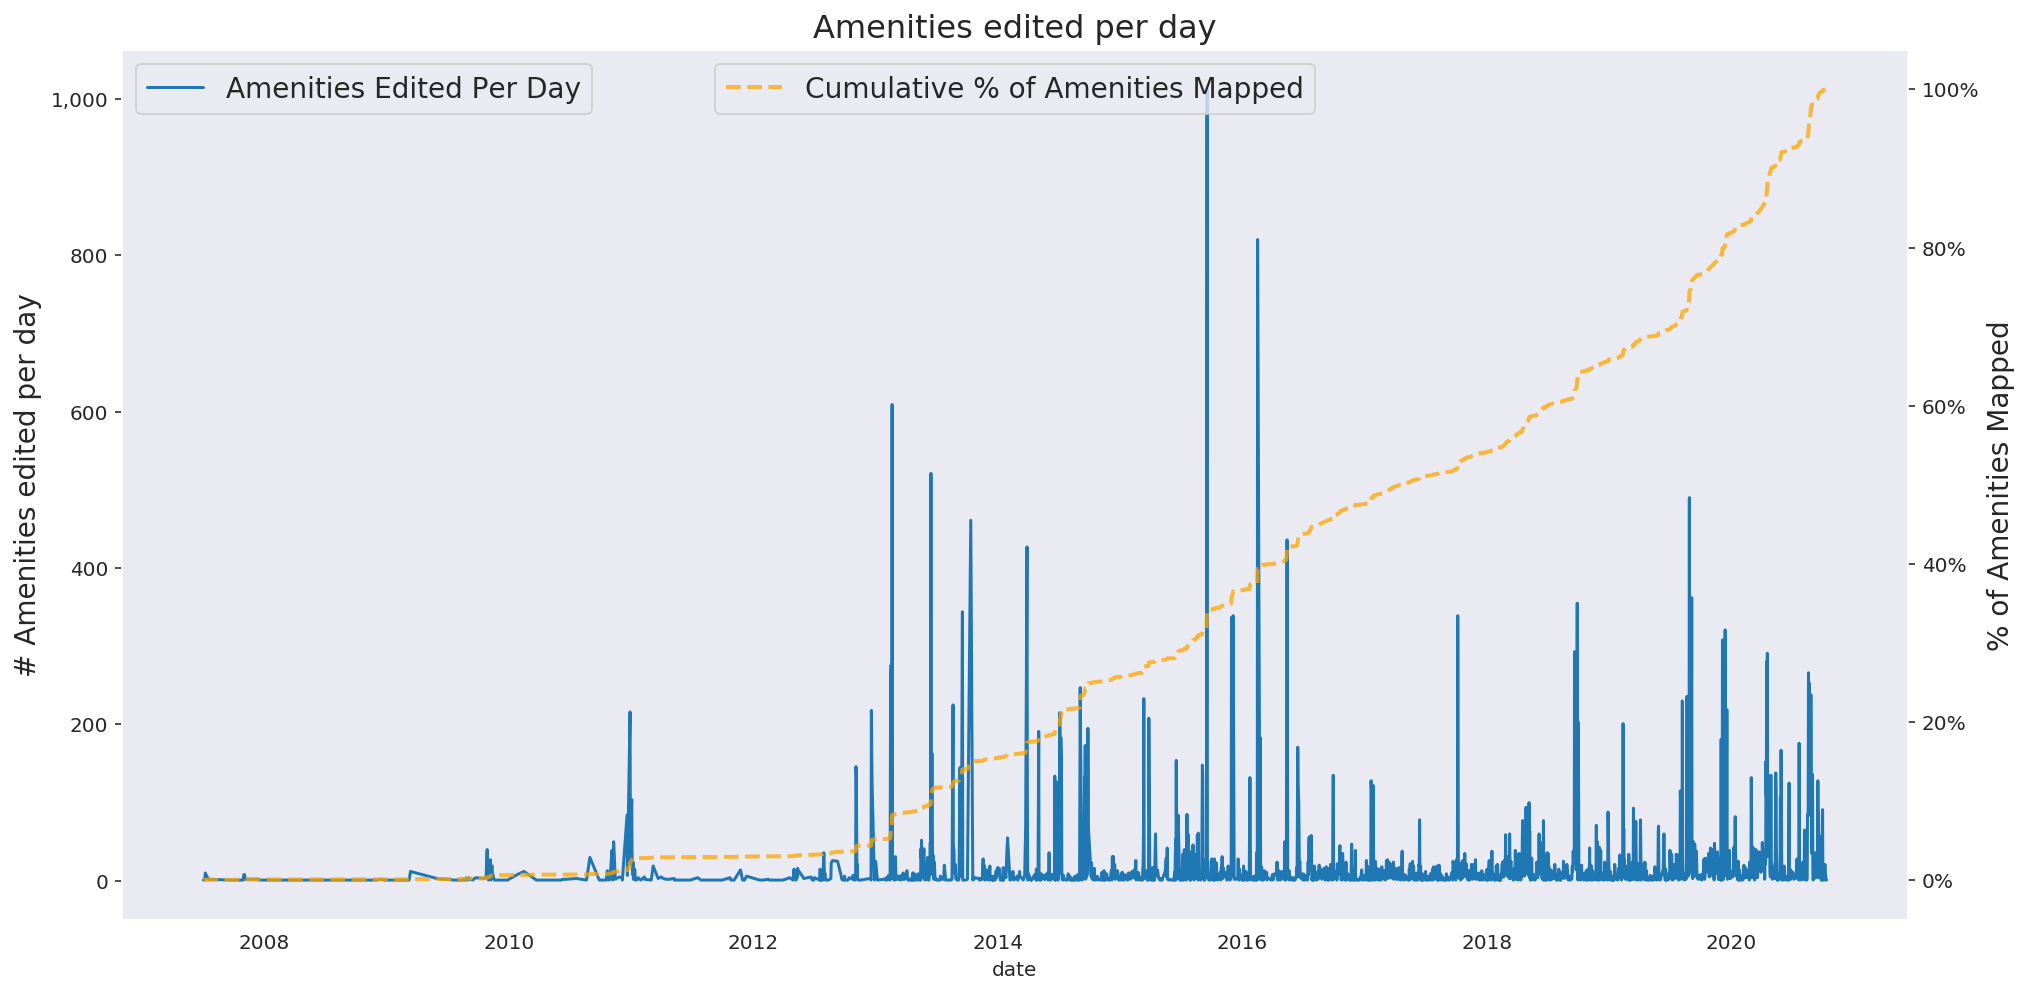

In [128]:
sns.set_style("dark")
a_gb_date = amenities.groupby('date').aggregate({'a_count':sum})
ax  = a_gb_date.plot(figsize=(16,8), legend=None)
ax2 = (a_gb_date.cumsum() / a_gb_date.a_count.sum()*100).plot(ax=ax.twinx(), legend=None, 
      color='orange', style="--", alpha=0.75, lw=2)
ax.set_title("Amenities edited per day", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{:,}".format(int(x))))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}%".format(int(x))))
ax.legend(["Amenities Edited Per Day"], loc='upper left', fontsize=14)
ax2.legend(["Cumulative % of Amenities Mapped"], loc='upper center', fontsize=14);
ax.set_ylabel("# Amenities edited per day", fontsize=14)
ax2.set_ylabel("% of Amenities Mapped", fontsize=14);